In [2]:
%%time
# for development, changes in other modules have to be reloaded to reflect changes
%load_ext autoreload
%autoreload 1

import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn 
import os, sys
import SimpleITK as sitk

%aimport config 
sys.path.append(config.lib_dir)
%aimport utils
%aimport segment 
%aimport match 
%aimport register 
%aimport evaluate 
%aimport qc 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 15.6 ms, sys: 15.6 ms, total: 31.2 ms
Wall time: 1.11 ms


From readme...


manual QC can be performed by passing either a dictionary (in results.ipynb) or as a json file (restitch_cores.py --qc /path/to/file.json) of cores that should not be restiched. For an example of a properly formatted json file, see here.

```json
{
    "R0":[23,3,42,35,19,79,17,22],
    "R1":[15,12,60,54,48,38,70,62],
    "R2":[30,46,8,24,80,9,31,44,76]
}
```

In [3]:
# These must be adjusted to your specific experiment
unreg_path    = '/mnt/z/Marilyne/Axioscan/6-Dhivya/split/No_Scene/'
reg_path      = './registered_imgs/'
results_path  = './registered_cores/aggregated_results.csv'
slide_name    = 'D1'
scene_name    = 'None'

In [4]:
res = pd.read_csv(results_path)

res = res.assign(round_num = [int(x[1:]) for x in res['round'].values])

# select only registered results -- keep R0 unregistered as this is the aligned reference 
reg_res = res[(res.status == 'registered') | (res['round'] == 'R0')]

reg_res.head()

,status,core,round,color_channel,path,img_name,protein,center_x,center_y,width,...,scene,note,jacaard_coef,dice_coef,volume_similarity,false_pos_err,false_neg_err,hausdorff_dist,registered_path,round_num
0,registered,0,R5,c1,registered_core=0_round=R5_color=c1.tif,R5_BCLxL.CD68.PD1.pATM_D1_2020_10_08__9273_c1_...,BCLxL.CD68.PD1.pATM,2236,221,106,...,None,ORG,0.137354,0.241532,1.37132,0.856714,0.231622,373.562584,/mnt/e/CycIF_analysis/registration_outputs/6-D...,5
1,registered,0,R5,c2,registered_core=0_round=R5_color=c2.tif,NaN,NaN,2236,221,106,...,None,ORG,0.137354,0.241532,1.37132,0.856714,0.231622,373.562584,/mnt/e/CycIF_analysis/registration_outputs/6-D...,5
2,registered,0,R5,c3,registered_core=0_round=R5_color=c3.tif,NaN,NaN,2236,221,106,...,None,ORG,0.137354,0.241532,1.37132,0.856714,0.231622,373.562584,/mnt/e/CycIF_analysis/registration_outputs/6-D...,5
3,registered,0,R5,c4,registered_core=0_round=R5_color=c4.tif,NaN,NaN,2236,221,106,...,None,ORG,0.137354,0.241532,1.37132,0.856714,0.231622,373.562584,/mnt/e/CycIF_analysis/registration_outputs/6-D...,5
4,registered,0,R5,c5,registered_core=0_round=R5_color=c5.tif,NaN,NaN,2236,221,106,...,None,ORG,0.137354,0.241532,1.37132,0.856714,0.231622,373.562584,/mnt/e/CycIF_analysis/registration_outputs/6-D...,5


# Registration Success Distribution 

We'll use `dice coefficient` as our registration metric. 

<AxesSubplot:xlabel='dice_coef', ylabel='Count'>

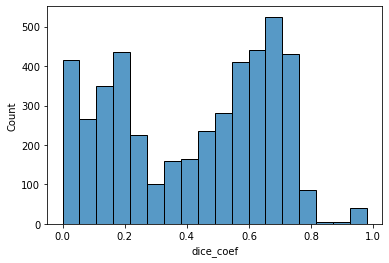

In [10]:
sbn.histplot(x='dice_coef', data=reg_res)

# Evaluate the effect of `Round` on registration

<AxesSubplot:xlabel='round_num', ylabel='dice_coef'>

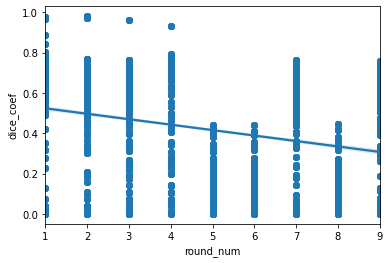

In [5]:
sbn.regplot(x='round_num', y='dice_coef', data=reg_res)

# Evaluate `core label` interaction with registration

core labels are assigned based on size of the segmented core in the R0 dapi round.

<AxesSubplot:xlabel='core', ylabel='dice_coef'>

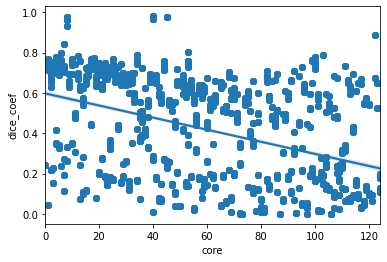

In [6]:
sbn.regplot(x='core', y='dice_coef', data=reg_res)

# Core size and registration

<AxesSubplot:xlabel='Volume (nm^3)', ylabel='dice_coef'>

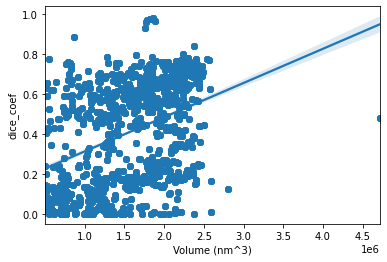

In [7]:
sbn.regplot(x='Volume (nm^3)', y='dice_coef', data=reg_res)

# Core position (x,y) on registration

<AxesSubplot:xlabel='center_x', ylabel='dice_coef'>

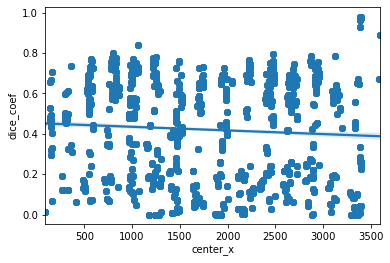

In [8]:
sbn.regplot(x='center_x', y='dice_coef', data=reg_res)

<AxesSubplot:xlabel='center_y', ylabel='dice_coef'>

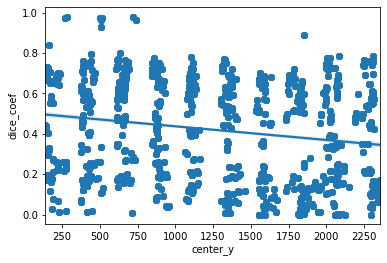

In [9]:
sbn.regplot(x='center_y', y='dice_coef', data=reg_res)

# Regress out round effects 

One option is to try and remove the effects of degraded or missing tissue which accumulates throug the rounds by regressing out or centering each round. 

This assumes that each round's *majority* of cores register well. If this is not the case, then this can seriously effect the usefulness of QC. 

In [11]:
stats = reg_res.groupby('round')['dice_coef'].agg(['mean', 'std']).reset_index()
stats=stats.rename({'mean':'mean_dice', 'std':'std_dice'}, axis=1)
reg_res = reg_res.merge(stats, on ='round', how='left').assign(dice_zeroed=lambda x: x.dice_coef - x.mean_dice)

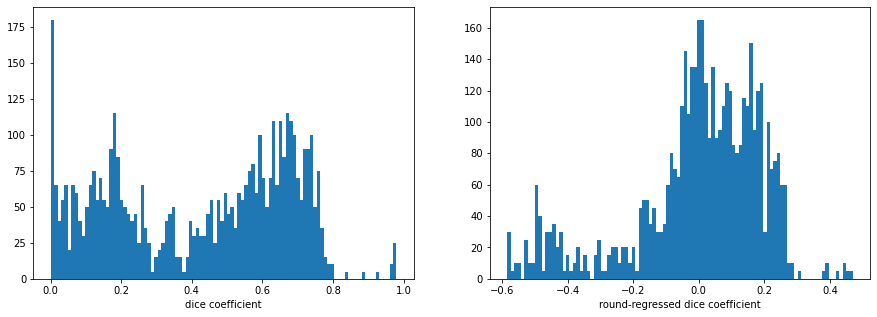

In [19]:
f, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].set_xlabel('dice coefficient')
axes[0].hist(reg_res.dice_coef, bins=100)

axes[1].set_xlabel('round-regressed dice coefficient')
axes[1].hist(reg_res.dice_zeroed, bins=100)

plt.show()